In [64]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import time


class Utils:
    def __init__(self, device: str = "cuda"):
        self.dev = device

utils = Utils()


class Base(nn.Module):
    """ This class is the base structure for all of classification/regression DNN models.
    Mainly, it provides the general methods for training, evaluating model and predcting the given data.
    """

    def fit(self, train_loader, valid_loader, out, epochs=100, lr=1e-4):
        """Training the DNN model, similar to the scikit-learn or Keras style.
        In the end, the optimal value of parameters will also be persisted on the hard drive.
        Arguments:
            train_loader (DataLoader): Data loader for training set,
                including m X n target FloatTensor and m X l label FloatTensor
                (m is the No. of sample, n is the No. of features, l is the No. of classes or tasks)
            valid_loader (DataLoader): Data loader for validation set.
                The data structure is as same as loader_train.
            out (str): the file path for the model file (suffix with '.pkg')
                and log file (suffix with '.log').
            epochs(int, optional): The maximum of training epochs (default: 100)
            lr (float, optional): learning rate (default: 1e-4)
        """

        if 'optim' in self.__dict__:
            optimizer = self.optim
        else:
            optimizer = optim.Adam(self.parameters(), lr=lr)

        # record the minimum loss value based on the calculation of loss function by the current epoch
        best_loss = np.inf
        # record the epoch when optimal model is saved.
        last_save = 0
        log = open(out + '.log', 'w')
        for epoch in range(epochs):
            t0 = time.time()
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * (1 - 1 / epochs) ** (epoch * 10)
            for i, (Xb, yb) in enumerate(train_loader):
                # Batch of target tenor and label tensor
                Xb, yb = Xb.to(utils.dev), yb.to(utils.dev)
                optimizer.zero_grad()
                # predicted probability tensor
                y_ = self(Xb, istrain=True)
                # ignore all of the NaN values
                ix = yb == yb
                yb, y_ = yb[ix], y_[ix]
                wb = torch.Tensor(yb.size()).to(utils.dev)
                wb[yb == 3.99] = 0.1
                wb[yb != 3.99] = 1
                # loss function calculation based on predicted tensor and label tensor
                loss = self.criterion(y_ * wb, yb * wb)
                loss.backward()
                optimizer.step()
            # loss value on validation set based on which optimal model is saved.
            loss_valid = self.evaluate(valid_loader)
            print('[Epoch: %d/%d] %.1fs loss_train: %f loss_valid: %f' % (
                epoch, epochs, time.time() - t0, loss.item(), loss_valid), file=log)
            if loss_valid < best_loss:
                torch.save(self.state_dict(), out + '.pkg')
                print('[Performance] loss_valid is improved from %f to %f, Save model to %s' %
                      (best_loss, loss_valid, out + '.pkg'), file=log)
                best_loss = loss_valid
                last_save = epoch
            else:
                print('[Performance] loss_valid is not improved.', file=log)
                # early stopping, if the performance on validation is not improved in 100 epochs.
                # The model training will stop in order to save time.
                if epoch - last_save > 100: break
        log.close()
        self.load_state_dict(torch.load(out + '.pkg'))

    def evaluate(self, loader):
        """Evaluating the performance of the DNN model.
        Arguments:
            loader (torch.util.data.DataLoader): data loader for test set,
                including m X n target FloatTensor and l X n label FloatTensor
                (m is the No. of sample, n is the No. of features, l is the No. of classes or tasks)
        Return:
            loss (float): the average loss value based on the calculation of loss function with given test set.
        """
        loss = 0
        for Xb, yb in loader:
            Xb, yb = Xb.to(utils.dev), yb.to(utils.dev)
            y_ = self.forward(Xb)
            ix = yb == yb
            yb, y_ = yb[ix], y_[ix]
            wb = torch.Tensor(yb.size()).to(utils.dev)
            wb[yb == 3.99] = 0.1
            wb[yb != 3.99] = 1
            loss += self.criterion(y_ * wb, yb * wb).item()
        loss = loss / len(loader)
        return loss

    def predict(self, loader):
        """Predicting the probability of each sample in the given dataset.
        Arguments:
            loader (torch.util.data.DataLoader): data loader for test set,
                only including m X n target FloatTensor
                (m is the No. of sample, n is the No. of features)
        Return:
            score (ndarray): probability of each sample in the given dataset,
                it is a m X l FloatTensor (m is the No. of sample, l is the No. of classes or tasks.)
        """
        score = []
        for Xb, yb in loader:
            Xb = Xb.to(utils.dev)
            y_ = self.forward(Xb)
            score.append(y_.detach().cpu())
        score = torch.cat(score, dim=0).numpy()
        return score

In [65]:
class MTFullyConnected(Base):
    """Multi-task DNN classification/regression model. It contains four fully connected layers
    between which are dropout layer for robustness.
    Arguments:
        n_dim (int): the No. of columns (features) for input tensor
        n_task (int): the No. of columns (tasks) for output tensor.
        is_reg (bool, optional): Regression model (True) or Classification model (False)
    """

    def __init__(self, n_dim, n_task, is_reg=False):
        super(MTFullyConnected, self).__init__()
        self.n_task = n_task
        self.dropout = nn.Dropout(0.25)
        self.fc0 = nn.Linear(n_dim, 4000)
        self.fc1 = nn.Linear(4000, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.output = nn.Linear(1000, n_task)
        self.is_reg = is_reg
        if is_reg:
            # loss function for regression
            self.criterion = nn.MSELoss()
        else:
            # loss function and activation function of output layer for multiple classification
            self.criterion = nn.BCELoss()
            self.activation = nn.Sigmoid()
        self.to(utils.dev)

    def forward(self, X, istrain=False):
        """Invoke the class directly as a function
        Arguments:
            X (FloatTensor): m X n FloatTensor, m is the No. of samples, n is the No. of features.
            istrain (bool, optional): is it invoked during training process (True)
                or just for prediction (False)
        Return:
            y (FloatTensor): m X l FloatTensor, m is the No. of samples, n is the No. of tasks
        """
        y = F.relu(self.fc0(X))
        if istrain:
            y = self.dropout(y)
        y = F.relu(self.fc1(y))
        if istrain:
            y = self.dropout(y)
        y = F.relu(self.fc2(y))
        if istrain:
            y = self.dropout(y)
        if self.is_reg:
            y = self.output(y)
        else:
            y = self.activation(self.output(y))
        return y

In [138]:
import pandas as pd
from rdkit.Chem import PandasTools
from rxitect.chem.utils import calc_fp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
df = pd.read_table("../data/processed/multitask_ligand_activity.tsv")
qsar_data_train = df[df.temporal_split_test == False]
qsar_data_test = df[df.temporal_split_test == True]
PandasTools.AddMoleculeColumnToFrame(qsar_data_train, 'smiles', 'mol')
PandasTools.AddMoleculeColumnToFrame(qsar_data_test, 'smiles', 'mol')
qsar_data_train["fingerprint"] = qsar_data_train.mol.apply(calc_fp)
qsar_data_test["fingerprint"] = qsar_data_test.mol.apply(calc_fp)

In [133]:
X_train, y_train = qsar_data_train.fingerprint.values, qsar_data_train[["CHEMBL226", "CHEMBL240", "CHEMBL251"]].values
X_test, y_test = qsar_data_test.fingerprint.values, qsar_data_test[["CHEMBL226", "CHEMBL240", "CHEMBL251"]].values

In [134]:
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(np.stack(X_train))
X_test = X_scaler.transform(np.stack(X_test))

In [135]:
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_test = feature_select.transform(X_test)

In [66]:
NET = MTFullyConnected(X_train.shape[1], y_train.shape[1], is_reg=True)

In [69]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256)

In [73]:
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256)

In [74]:
NET.fit(train_loader, test_loader, "multitask_dnn")

In [75]:
NET.eval()
a = NET.evaluate(train_loader)

In [89]:
def predict_smiles(model, smiles):
    fp =calc_fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=utils.dev).float()
    prediction = model(fp_tensor)
    pchembl_value =  prediction.cpu().detach().numpy()
    # pchembl_value = scaler.inverse_transform(prediction.cpu().detach().numpy())
    # return pchembl_value[0][0]
    return pchembl_value[0]

In [90]:
predict_smiles(NET, "OCCNc1nc(-c2ccco2)c2cnn(CCc3ccccc3)c2n1")

array([6.1285763, 5.413839 , 7.1775312], dtype=float32)

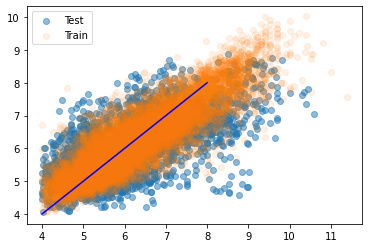

In [136]:
to_keep_train = (y_train != 3.99).all(axis=1)
y_train_clean = y_train[to_keep_train]
X_train_clean = X_train[to_keep_train.reshape(-1)]

to_keep_test = (y_test != 3.99).all(axis=1)
y_test_clean = y_test[to_keep_test]
X_test_clean = X_test[to_keep_test.reshape(-1)]

# reg.cuda()
# reg.eval()
import matplotlib.pyplot as plt
NET.cuda()
y_pred_train = NET(torch.tensor(X_train_clean, dtype=torch.float32, device=utils.dev))
y_pred_test = NET(torch.tensor(X_test_clean, dtype=torch.float32, device=utils.dev))
y_train_clean = torch.from_numpy(y_train_clean)
y_test_clean = torch.from_numpy(y_test_clean)

plt.scatter(y=y_pred_test.cpu().detach().numpy().reshape(-1), x=y_test_clean.cpu().detach().numpy().reshape(-1, 1), alpha=0.5, label="Test")
plt.scatter(y=y_pred_train.cpu().detach().numpy().reshape(-1), x=y_train_clean.cpu().detach().numpy().reshape(-1, 1), alpha=0.1, label="Train")
plt.legend()
plt.plot()
plt.plot([4, 8], [4,8], c="b")

In [141]:
NET.predict(test_loader)

array([[5.4207134, 4.6398406, 5.5355   ],
       [5.2402835, 4.9190164, 5.2961574],
       [6.3843813, 5.97805  , 6.221181 ],
       ...,
       [6.217992 , 4.962089 , 6.4063907],
       [6.1778574, 5.2621675, 6.2857223],
       [5.625533 , 4.9143863, 5.749237 ]], dtype=float32)